In [1]:
import numpy as np
import pandas as pd
from datetime import *

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.metrics import r2_score

import pylab as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.1.0


## Get data

In [5]:
with open('steps.dat', 'r') as handle:
    steps = handle.readline().strip().split()
steps_ = [f's{i}' for i in range(len(steps))]

In [6]:
df = pd.read_csv(
    'combined_data_step_7.csv',
    dtype={'fips': str}).set_index('fips')
df.rename(columns={a: b for a, b in zip(steps, steps_)}, inplace=True)
df.head()

,65yrs,minority,black,hispanic,population,perc_65yrs,perc_minority,perc_black,perc_hispanic,poverty,...,s21,s22,s23,s24,s25,s26,s27,s28,s29,covid
fips,,,,,,,,,,,,,,,,,,,,,
01001,8924,13262,11237,1671,55869,0.159731,0.237377,0.201131,0.029909,7587,...,45.0,62.0,61.0,241.0,91.0,54.0,80.0,85.0,65.0,2126
01003,46830,28036,19593,10534,223234,0.209780,0.125590,0.087769,0.047188,21069,...,270.0,235.0,210.0,295.0,430.0,571.0,142.0,160.0,287.0,6768
01005,4861,12552,11906,1117,24686,0.196913,0.508466,0.482298,0.045248,6788,...,-2.0,-8.0,4.0,210.0,52.0,39.0,21.0,35.0,54.0,1055
01007,3733,5203,4763,623,22394,0.166696,0.232339,0.212691,0.027820,4400,...,20.0,27.0,26.0,52.0,26.0,24.0,48.0,49.0,53.0,861
01009,10814,2414,978,5582,57826,0.187009,0.041746,0.016913,0.096531,7527,...,73.0,58.0,52.0,428.0,69.0,44.0,49.0,103.0,118.0,2009


In [7]:
steps_vec = [x.split('-') for x in steps]
steps = [f'2020-{m.zfill(2)}-{d.zfill(2)}' for m, d in steps_vec]

last = datetime.strptime(steps[-1], '%Y-%m-%d')
next_1 = (last + timedelta(days=1)).date()
next_2 = (last + timedelta(days=2)).date()

In [8]:
df['urban_risk'] = df['perc_urban_pop'] * (df['risk_flu'] - df['risk_flu'].min())
covariates = [
    'population', 
    'perc_65yrs', 
    'perc_minority', 
    'perc_black', 
    'perc_hispanic', 
    'perc_poverty', 
    'perc_urban_pop',
    'income',
    'risk', 
    'risk_flu',
    'urban_risk'
]

df_z = df[steps_].copy()
for c in covariates:
    mean, std = df[c].mean(), df[c].std()
    df_z[c] = (df[c] - mean) / std
df_z.head()

,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,perc_65yrs,perc_minority,perc_black,perc_hispanic,perc_poverty,perc_urban_pop,income,risk,risk_flu,urban_risk
fips,,,,,,,,,,,,,,,,,,,,,
01001,12,7.0,6.0,11.0,9.0,23.0,42.0,45.0,61.0,43.0,...,-0.794106,0.512705,0.741329,-0.489703,-0.225017,0.535824,0.480936,0.984276,1.006875,0.666999
01003,29,37.0,43.0,38.0,34.0,35.0,38.0,19.0,10.0,21.0,...,0.257409,-0.180113,-0.042334,-0.365711,-0.883379,0.526204,0.353735,1.225361,1.296454,0.817850
01005,2,7.0,9.0,14.0,11.0,15.0,21.0,26.0,45.0,40.0,...,-0.012923,2.192825,2.685016,-0.379632,2.589482,-0.291414,-1.333023,0.221392,0.420657,-0.240836
01007,4,9.0,13.0,8.0,8.0,3.0,5.0,8.0,14.0,5.0,...,-0.647773,0.481481,0.821243,-0.504693,1.091708,-0.310652,-0.483902,0.308118,0.436170,-0.249735
01009,10,2.0,8.0,11.0,9.0,4.0,1.0,4.0,12.0,9.0,...,-0.221003,-0.699751,-0.532156,-0.011632,-0.323771,-1.003223,-0.167862,0.566669,0.617627,-0.724261


In [5]:
rea_1015_1029 = np.array([65, 70, 52, 47, 65, 60, 64, 75, 85, 78, 59, 74, 74, 81])

## GLM

In [6]:
cov_prefix = 'population+perc_65yrs+perc_minority+perc_black+perc_hispanic+perc_poverty+income+'
cov = cov_prefix + 'perc_urban_pop+risk_flu+urban_risk'

In [7]:
cors = []
for i in range(len(steps_)):
    cur = steps_[i]
    formula = f'{cur}~{cov}'

    # Model fitting
    model = smf.glm(
        formula=formula,
        data=df_z,
        family=sm.families.Poisson(sm.families.links.log())
    ).fit()
    print(f'{model.summary()}\n\n')
    
    prd = model.predict()
    cor = pd.DataFrame(
        data={'prd': prd, 'grd': df_z[cur].values}, 
        index=df.index).corr().loc['prd', 'grd']
    print(cor)
    cors.append(cor)
    
    df_z[cur + '_p'] = model.predict()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     s0   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.1220e+05
Date:                Mon, 02 Nov 2020   Deviance:                   4.1454e+05
Time:                        01:08:13   Pearson chi2:                 7.18e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.0954      0.007    280.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     s4   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Mon, 02 Nov 2020   Deviance:                   2.6374e+05
Time:                        01:08:13   Pearson chi2:                 1.12e+06
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.5841      0.006    403.


0.7646084148765532
                 Generalized Linear Model Regression Results                  
Dep. Variable:                     s8   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Mon, 02 Nov 2020   Deviance:                   1.3971e+05
Time:                        01:08:13   Pearson chi2:                 2.43e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.511

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    s13   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Mon, 02 Nov 2020   Deviance:                   2.4871e+05
Time:                        01:08:14   Pearson chi2:                 3.78e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.0472      0.006    552.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    s19   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Mon, 02 Nov 2020   Deviance:                   1.9995e+05
Time:                        01:08:14   Pearson chi2:                 3.12e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.5484      0.004    912.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    s25   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Mon, 02 Nov 2020   Deviance:                   1.9505e+05
Time:                        01:08:15   Pearson chi2:                 2.87e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.6995      0.003   1067.

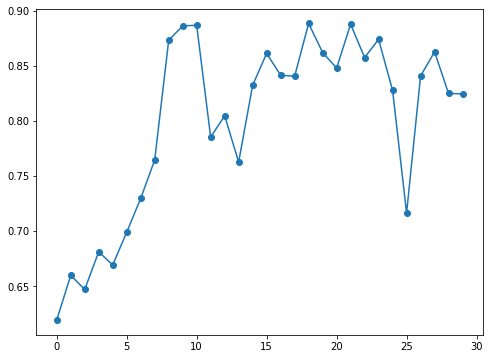

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(cors, marker='o')

## Forcasting

### make tensorflow regressor a little easier to use

In [9]:
class tfRegr:
    
    def __init__(self, 
                 epoch=100, 
                 verbose=False, 
                 validation_split=0.2, 
                 learning_rate=.1):
        
        self. normalizer = preprocessing.Normalization()
        self.ep = epoch
        self.vb = verbose
        self.vs = validation_split
        self.lr = learning_rate
    
    def fit(self, X, y):
        self.normalizer.adapt(X)

        self.model = tf.keras.Sequential([
            self.normalizer,
            layers.Dense(units=1)
        ])

        self.model.compile(
            optimizer=tf.optimizers.Adam(learning_rate=self.lr),
            loss='mean_absolute_error'
        )

        self.history = self.model.fit(
            X, y,
            epochs=self.ep,
            verbose=self.vb, # logging
            validation_split=self.vs # Calculate validation results on a fraction of the training data
        )
        return self.model

In [10]:
df_data = df_z[[f's{i}' for i in range(len(steps_))] + [f's{i}_p' for i in range(len(steps_))]].copy()
regrs = {
    'RF': RandomForestRegressor(min_samples_split=2), 
    'ET': ExtraTreesRegressor(min_samples_split=2), 
    'TF': tfRegr(),
}
r2s_nxt_1 = {regr_name: [] for regr_name in regrs}
r2s_nxt_2 = {regr_name: [] for regr_name in regrs}

In [12]:
for i in range(1, len(steps_)):

    cur_idx = int(steps_[i][1:])
    prv, cur = steps_[i - 1], steps_[i] 
    nxt_1, nxt_2 = f's{cur_idx + 1}', f's{cur_idx + 2}'
    
    print(f'{steps[i]}:')
    
    # Training regressor
    X_train = df_data[[prv, cur + '_p']].values
    y_train = df_data[cur].values
        
    for regr_name, regr in regrs.items():
        regr = regr.fit(X_train, y_train)
    
        # Predicting next 1 step
        X_nxt_1 = df_data[[cur, cur + '_p']].values
        y_nxt_1 = regr.predict(X_nxt_1)
        
        df_data[cur + f'_1p{regr_name}'] = y_nxt_1
        sum_nxt_1 = y_nxt_1.sum()
        
        # Predicting next 2 step
        X_nxt_2 = df_data[[cur + f'_1p{regr_name}', cur + '_p']].values
        y_nxt_2 = regr.predict(X_nxt_2)
        
        df_data[cur + f'_2p{regr_name}'] = y_nxt_2
        sum_nxt_2 = y_nxt_2.sum()
        
        # evaluating and showing results
        if i < len(steps_) - 1:
            y_test = df_data[nxt_1].values
            r2 = r2_score(y_test, y_nxt_1)
            r2s_nxt_1[regr_name].append(r2)
            sum_grd = y_test.sum()
            print(f'\t{regr_name}, next 1: sum = {sum_grd:.0f}, predicted sum = {sum_nxt_1:.0f}, r2 = {r2: .3f}')
            
            if i < len(steps_) - 2:
                y_test = df_data[nxt_2].values
                r2 = r2_score(y_test, y_nxt_2)
                r2s_nxt_2[regr_name].append(r2)
                sum_grd = y_test.sum()
                print(f'\t{regr_name}, next 2: sum = {sum_grd:.0f}, predicted sum = {sum_nxt_2:.0f}, r2 = {r2: .3f}')
            else:
                print(f'\t{regr_name}, next 2: predicted sum = {sum_nxt_2:.0f}')
        else:
            print(f'\t{regr_name}, next 1: predicted sum = {sum_nxt_1:.0f}')
            print(f'\t{regr_name}, next 2: predicted sum = {sum_nxt_2:.0f}')

4-11:
	RF, next 1: sum = 202912, predicted sum = 170697, r2 =  0.901
	RF, next 2: sum = 206731, predicted sum = 142322, r2 =  0.776
	ET, next 1: sum = 202912, predicted sum = 174209, r2 =  0.888
	ET, next 2: sum = 206731, predicted sum = 148126, r2 =  0.780


/usr/local/lib64/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib64/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


	TF, next 1: sum = 202912, predicted sum = 151842, r2 =  0.818
	TF, next 2: sum = 206731, predicted sum = 121218, r2 =  0.613
4-18:
	RF, next 1: sum = 206731, predicted sum = 195328, r2 =  0.909
	RF, next 2: sum = 192584, predicted sum = 187557, r2 =  0.724
	ET, next 1: sum = 206731, predicted sum = 192972, r2 =  0.892
	ET, next 2: sum = 192584, predicted sum = 190933, r2 =  0.705
	TF, next 1: sum = 206731, predicted sum = 173122, r2 =  0.904
	TF, next 2: sum = 192584, predicted sum = 151883, r2 =  0.776
4-25:
	RF, next 1: sum = 192584, predicted sum = 214425, r2 =  0.862
	RF, next 2: sum = 175327, predicted sum = 219458, r2 =  0.689
	ET, next 1: sum = 192584, predicted sum = 217218, r2 =  0.842
	ET, next 2: sum = 175327, predicted sum = 227024, r2 =  0.647
	TF, next 1: sum = 192584, predicted sum = 192411, r2 =  0.893
	TF, next 2: sum = 175327, predicted sum = 181269, r2 =  0.775
5-2:
	RF, next 1: sum = 175327, predicted sum = 182607, r2 =  0.931
	RF, next 2: sum = 156433, predicted s

	TF, next 1: sum = 288955, predicted sum = 189152, r2 =  0.730
	TF, next 2: sum = 298956, predicted sum = 161613, r2 =  0.423
9-19:
	RF, next 1: sum = 298956, predicted sum = 331064, r2 =  0.689
	RF, next 2: sum = 293805, predicted sum = 368305, r2 =  0.798
	ET, next 1: sum = 298956, predicted sum = 332175, r2 =  0.713
	ET, next 2: sum = 293805, predicted sum = 364482, r2 =  0.789
	TF, next 1: sum = 298956, predicted sum = 300681, r2 =  0.757
	TF, next 2: sum = 293805, predicted sum = 311194, r2 =  0.860
9-26:
	RF, next 1: sum = 293805, predicted sum = 296619, r2 =  0.755
	RF, next 2: sum = 328692, predicted sum = 301559, r2 =  0.453
	ET, next 1: sum = 293805, predicted sum = 303591, r2 =  0.391
	ET, next 2: sum = 328692, predicted sum = 306915, r2 = -0.056
	TF, next 1: sum = 293805, predicted sum = 275971, r2 =  0.657
	TF, next 2: sum = 328692, predicted sum = 258449, r2 =  0.568
10-3:
	RF, next 1: sum = 328692, predicted sum = 295232, r2 =  0.889
	RF, next 2: sum = 380890, predicted 

In [13]:
print('next 1 week')
for regr_name, r2_arr in r2s_nxt_1.items():
    r2_arr = np.array(r2_arr)
    print(f'\t{regr_name}: {r2_arr.mean(): .3f}')

print('next 2 week')
for regr_name, r2_arr in r2s_nxt_2.items():    
    r2_arr = np.array(r2_arr)
    print(f'\t{regr_name}: {r2_arr.mean(): .3f}')

next 1 week
	RF:  0.864
	ET:  0.849
	TF:  0.872
next 2 week
	RF:  0.738
	ET:  0.716
	TF:  0.770


In [33]:
srs = []
grd = df_data[[f's{i}' for i in range(len(steps_))]].sum()
grd.name = 'grd'
srs.append(grd)

for key in regrs:
    cols = [x for x in df_data.columns if x.endswith(f'_1p{key}')]
    sr = df_data[cols].sum().astype(int)
    sr.index = [x[:-5] for x in sr.index]
    sr.name = key + '1'
    srs.append(sr)
    
    cols = [x for x in df_data.columns if x.endswith(f'_2p{key}')]
    sr = df_data[cols].sum().astype(int)
    sr.index = [x[:-5] for x in sr.index]
    sr.name = key + '2'
    srs.append(sr)

df_count = pd.concat(srs, join='outer', axis=1)
df_count.index = [int(s[1:]) for s in df_count.index]
df_count.sort_index(inplace=True)

grd1 = df_count['grd'][2: ]
grd1.index = range(1, len(grd1) + 1)
grd1.name = 'grd1'
# print(grd1)

grd2 = df_count['grd'][3: ]
grd2.index = range(1, len(grd2) + 1)
grd2.name = 'grd2'
# print(grd2)

df_count = df_count.join(grd1, how='outer').join(grd2, how='outer')
df_count.index = steps
df_count.drop(steps[0], inplace=True)
df_count['avg1'] = df_count[[f'{key}1' for key in regrs]].mean(axis=1).astype(int)
df_count['avg2'] = df_count[[f'{key}2' for key in regrs]].mean(axis=1).astype(int)

In [38]:
df_count.to_csv('forecast_ours_1.csv', float_format='%0.f')

In [35]:
xtl1 = list(df_count.index[1:].values) + [next_1]
xtl2 = list(df_count.index[2:].values) + [next_1, next_2]
xtls = [xtl1, xtl2] 

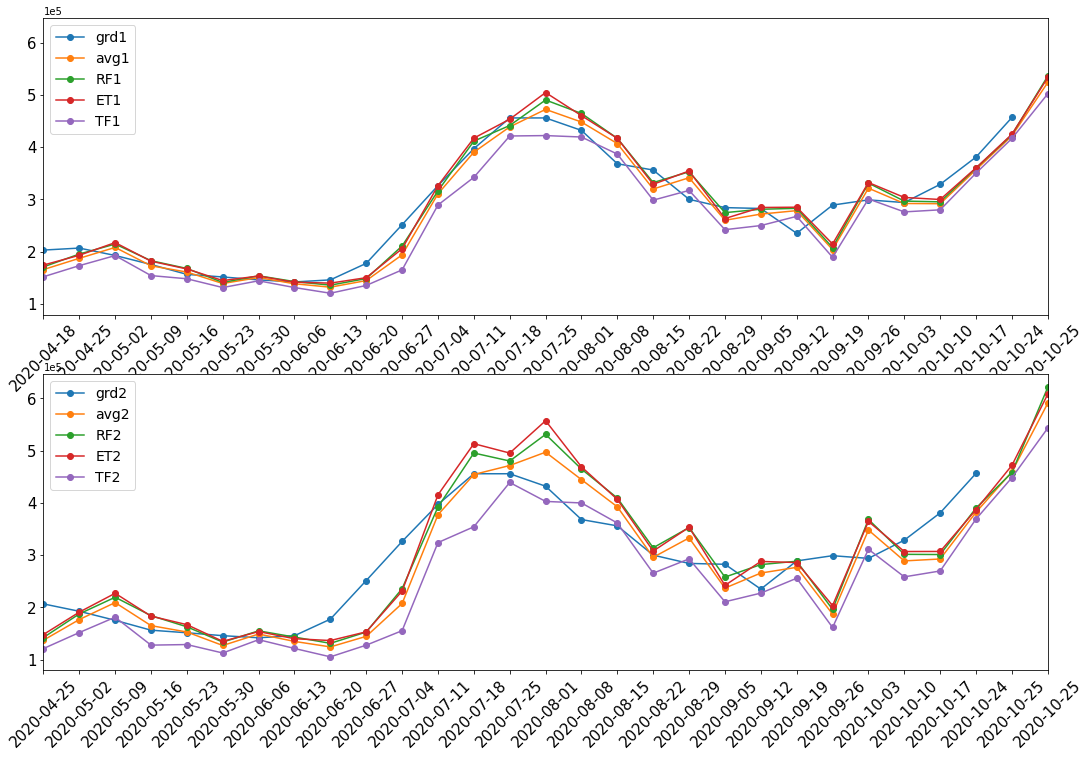

In [36]:
ylim = np.array([np.nanmin(df_count.values), np.nanmax(df_count.values)])
margin = (ylim[1] - ylim[0]) * .05
ylim = [ylim[0] - margin, ylim[1] + margin]

fig, axes = plt.subplots(2, 1, figsize=(18, 12))
for i in [1, 2]:
    ax = axes[i - 1]
    xtl = xtls[i - 1]
    df_count[[f'grd{i}']].plot(ax=ax, marker='o')
    df_count[[f'avg{i}']].plot(ax=ax, marker='o')
    for method in regrs:
        tmp_df = df_count[[f'{method}{i}']]
        tmp_df.plot(ax=ax, marker='o')
        
    ax.set_ylim(ylim)
    ax.set_xticks(range(len(xtl)))
    ax.set_xticklabels(xtl, rotation=45, ha='center')
    
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    ax.tick_params(axis='both', labelsize=15)
    ax.legend(prop=dict(size=14))

In [1]:
df_count_cumul = df_count.cumsum(axis=0)
ylim = np.array([np.nanmin(df_count_cumul.values), np.nanmax(df_count_cumul.values)])
margin = (ylim[1] - ylim[0]) * .05
ylim = [ylim[0] - margin, ylim[1] + margin]

fig, axes = plt.subplots(2, 1, figsize=(18, 12))

for i in [1, 2]:
    ax = axes[i - 1]
    xtl = xtls[i - 1]
    df_count_cumul[[f'grd{i}']].plot(ax=ax, marker='o')
    df_count_cumul[[f'avg{i}']].plot(ax=ax, marker='o')
    for method in regrs:
        tmp_df = df_count_cumul[[f'{method}{i}']]
        tmp_df.plot(ax=ax, marker='o')
    
    ax.set_ylim(ylim)
    
    ax.set_xticks(range(len(xtl)))
    ax.set_xticklabels(xtl, rotation=45, ha='center')
    
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    ax.tick_params(axis='both', labelsize=15)
    ax.legend(prop=dict(size=14))

NameError: name 'df_count' is not defined

# Ignore below

## autoregression